In [1]:
import os
import cv2
import torch
import helper
import time
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt

In [2]:
# define the path to the images and masks dataset
image_dataset_path = "dataset/images"
mask_dataset_path = "dataset/masks"

# define the test split
test_split = 0.15

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 0.001
num_epochs = 100
batch_size = 5

# define the input image dimensions
input_image_width = 400
input_image_height = 400

# define threshold to filter weak predictions
threshold = 0.5

# define the path to the base output directory
base_output = "output"

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = os.listdir(image_dataset_path)
maskPaths = os.listdir(image_dataset_path)
imageprefix = image_dataset_path + "/" 
maskprefix = image_dataset_path + "/"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB, and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        # Set a threshold value
        threshold_value = 127
        # Threshold the image
        ret, binary_mask = cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            binary_mask = self.transforms(binary_mask)
        # return a tuple of the image and its mask
        return (image, binary_mask)

In [5]:
# define transformations
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
    transforms=transform)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transform)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size)

[INFO] found 188 examples in the training set...
[INFO] found 34 examples in the test set...


In [6]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

In [7]:
print(f'x = shape: {images.shape}')
print(f'y = shape: {masks.shape}')

x = shape: torch.Size([10, 3, 400, 400])
y = shape: torch.Size([10, 1, 400, 400])


<AxesSubplot:>

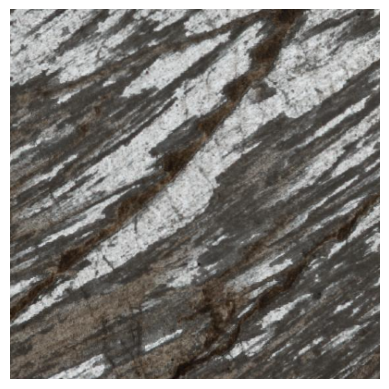

In [8]:
helper.imshow(images[0], normalize=False)

<AxesSubplot:>

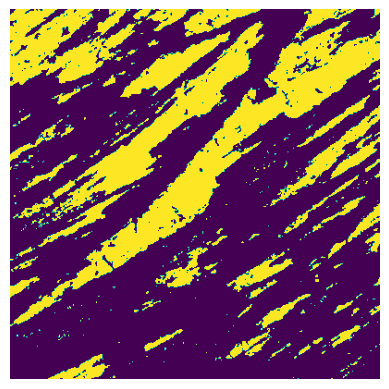

In [9]:
helper.imshow(masks[0], normalize=False)

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(400,400)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [11]:
# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [12]:
pred = unet(images.to(device))

In [13]:
images.size()

torch.Size([10, 3, 400, 400])

In [14]:
pred.size()

torch.Size([10, 1, 400, 400])

In [15]:
loss = lossFunc(pred, masks.to(device))

In [16]:
new_pred = pred.cpu()

<AxesSubplot:>

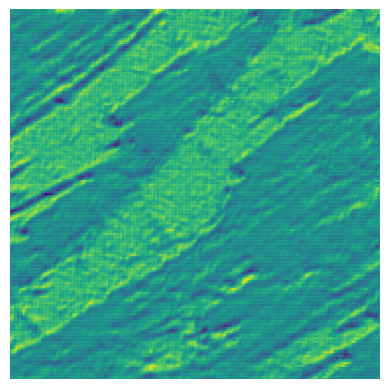

In [17]:
helper.imshow(new_pred[0].detach(), normalize=False)

[INFO] training the network...


 33%|████████████████████████████                                                        | 1/3 [00:21<00:43, 21.83s/it]

[INFO] EPOCH: 1/3
Train loss: 38.964283, Test loss: 1.8711


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:44<00:22, 22.26s/it]

[INFO] EPOCH: 2/3
Train loss: 0.636271, Test loss: 0.4695


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:06<00:00, 22.13s/it]

[INFO] EPOCH: 3/3
Train loss: 641.520569, Test loss: 0.6250
[INFO] total time taken to train the model: 66.40s


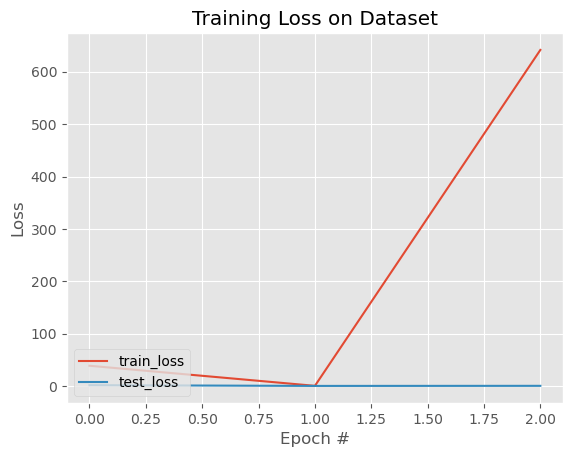

In [18]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [31]:
def prepare_plot(original_image: np.ndarray, original_mask: np.ndarray, predicted_mask: np.ndarray) -> None:
    """Prepares a plot with three subplots showing the original image, the ground truth mask, and the predicted mask."""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axes[0].imshow(original_image)
    axes[0].grid(False)
    axes[0].set_title("Image")
    axes[1].imshow(original_mask)
    axes[1].grid(False)
    axes[1].set_title("Original Mask")
    axes[2].imshow(predicted_mask)
    axes[2].grid(False)
    axes[2].set_title("Predicted Mask")
    fig.tight_layout()
    plt.show()


def make_predictions(model: torch.nn.Module, image_path: str) -> None:
    """Takes a trained model and an image file path and generates a predicted mask."""
    model.eval()

    with torch.no_grad():
        # Load image and ground truth mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        original = image.copy()

        filename = os.path.split(image_path)[-1]
        ground_truth_path = os.path.join(mask_dataset_path, filename)
        ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

        # Prepare input for model
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)

        # Generate predicted mask
        predicted_mask = model(image).squeeze()
        predicted_mask = predicted_mask.cpu().numpy()

        # Visualize results
        prepare_plot(original, ground_truth_mask, predicted_mask)

In [20]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(test_paths).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [21]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


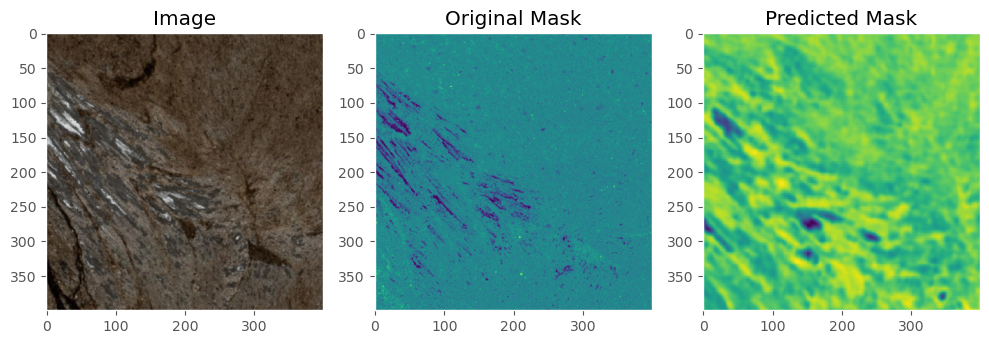

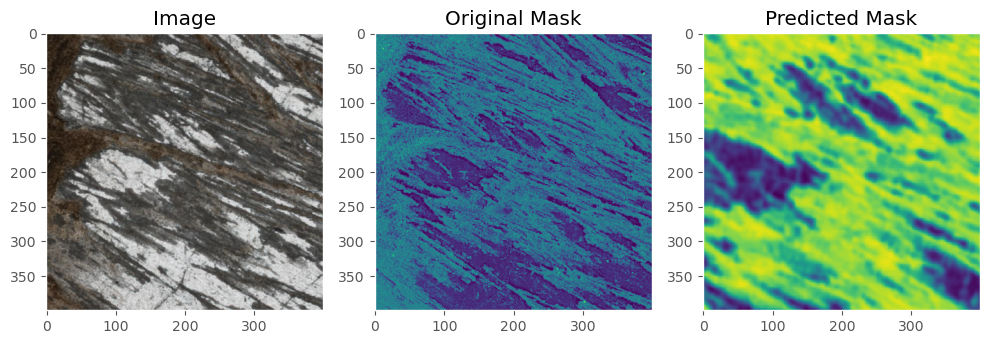

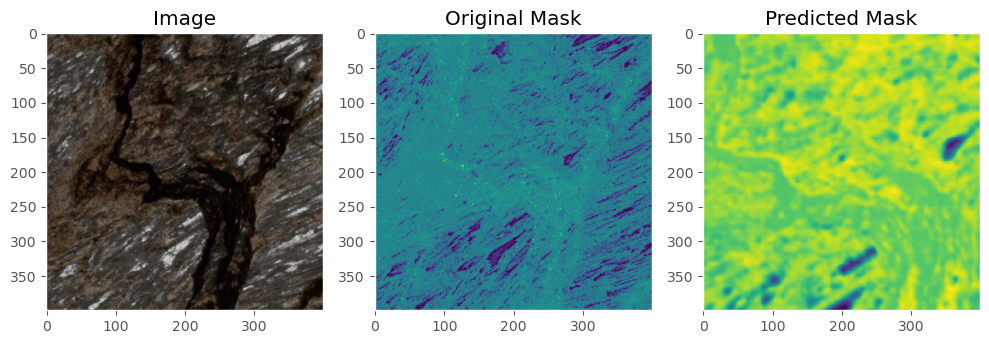

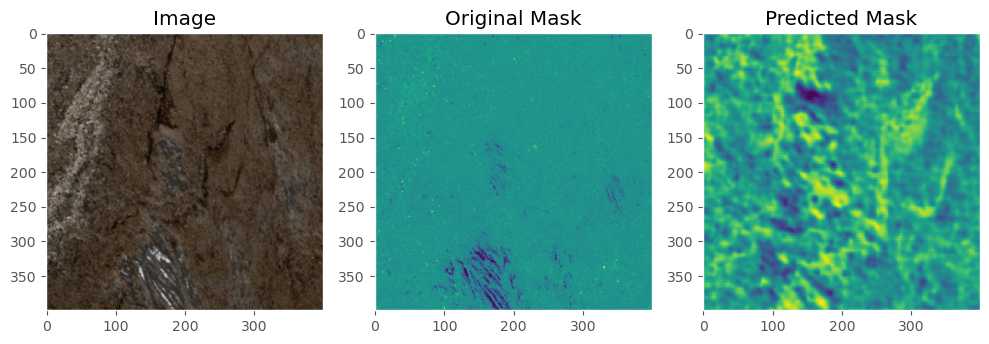

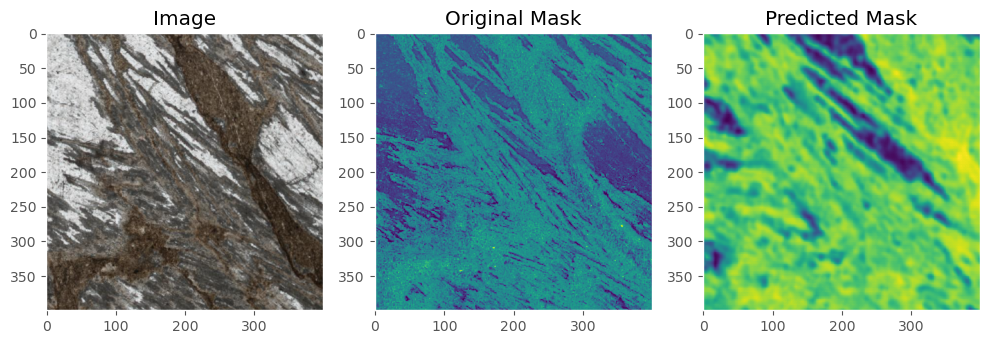

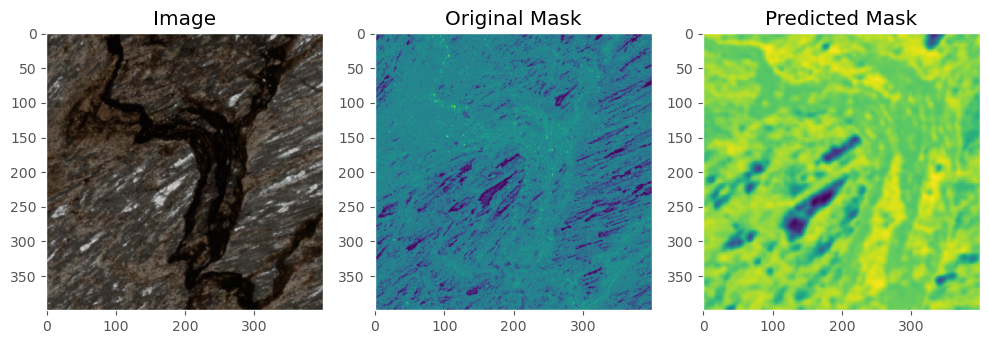

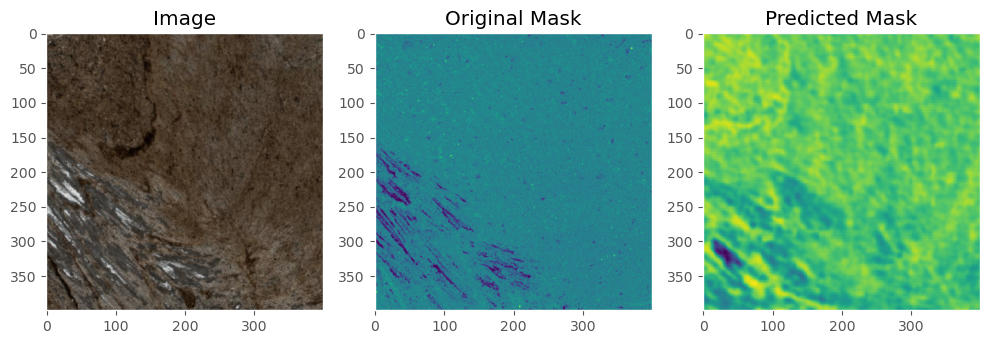

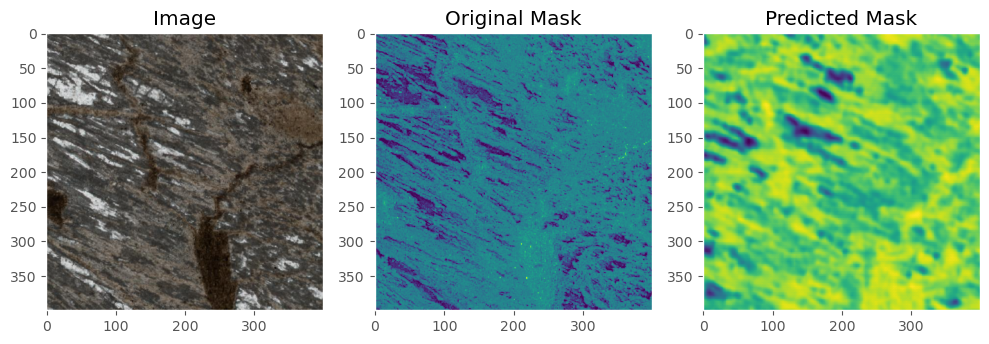

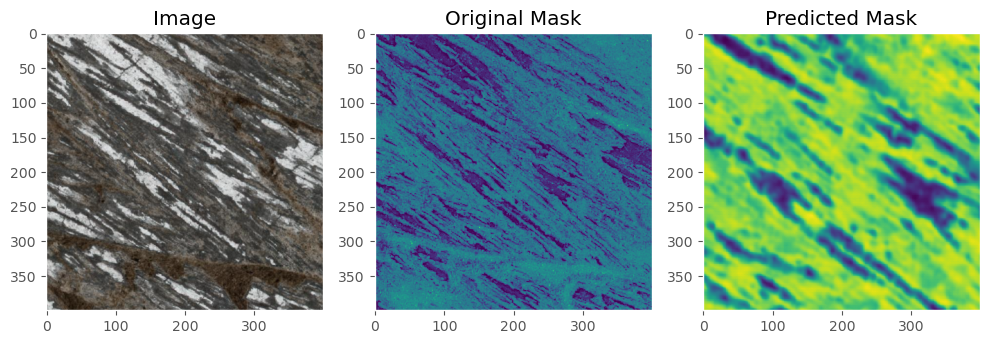

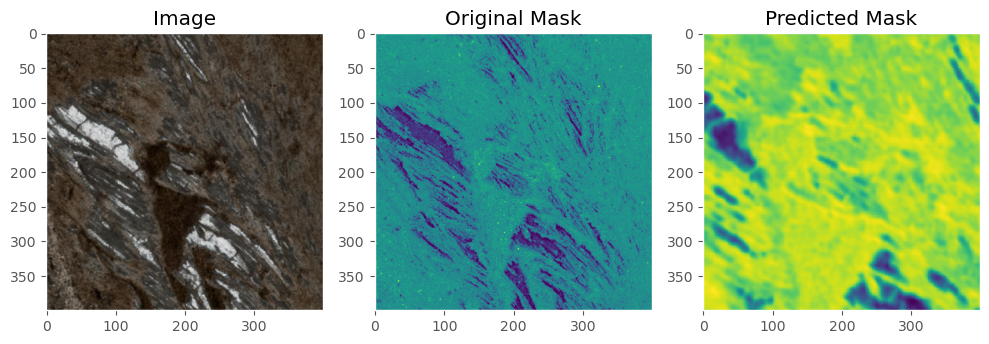

In [32]:
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)